In [1]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Full dataset
hourly_aq = pd.read_csv('../../aqi.csv')

## Feature generation

In [3]:
# Pivot the parameters to be useful for feature work
hourly_feat = hourly_aq.pivot(index=['datetime_est', 'site'], columns='parameter', values='report_value').reset_index()

# We want multiple features from the date. Let's create a bunch
hourly_feat['datetime_est'] = pd.to_datetime(hourly_feat['datetime_est'])
hourly_feat['year'] = hourly_feat['datetime_est'].dt.year
hourly_feat['month'] = hourly_feat['datetime_est'].dt.month
hourly_feat['day'] = hourly_feat['datetime_est'].dt.day
hourly_feat['date'] = hourly_feat['datetime_est'].dt.date
hourly_feat['month_day'] = hourly_feat['datetime_est'].dt.strftime('%m-%d')
hourly_feat['hour'] = hourly_feat['datetime_est'].dt.hour
hourly_feat['weekday'] = hourly_feat['datetime_est'].dt.day_name()
hourly_feat['weekday_num'] = hourly_feat['datetime_est'].dt.weekday
hourly_feat['is_weekend'] = hourly_feat['weekday_num'].apply(lambda x: 1 if x >= 5 else 0)
hourly_feat['week_of_year'] = hourly_feat['datetime_est'].dt.isocalendar().week
hourly_feat['quarter'] = hourly_feat['datetime_est'].dt.quarter

def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
hourly_feat['time_of_day'] = hourly_feat['hour'].apply(time_of_day)

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
hourly_feat['season'] = hourly_feat['datetime_est'].apply(get_season)

hourly_feat.columns

Index(['datetime_est', 'site', '4-12-01T23:00:00"', '6.2', 'AMBTEMP',
       'AREF_500', 'AZERO200', 'BAMRAW', 'BCSTAT', 'BLACK CARBON',
       ...
       'date', 'month_day', 'hour', 'weekday', 'weekday_num', 'is_weekend',
       'week_of_year', 'quarter', 'time_of_day', 'season'],
      dtype='object', name='parameter', length=142)

In [4]:
# Different stations use slightly different features for similar concepts. We
# would prefer to combine from a neighboring stations rather than impute.
meteorology_cols = [
    #'datetime_est', 'site',
    # Temp
    'OUT_T',
    # Wind
    'RWS', 'SONICWS', 'WNSP', 'Peak Wind Gust', 'SIGTHETA',
    # Wind dir
    'RWD', 'SONICWD', 'WNDR',
    # Other
    'BP', 'OUT_RH']

#meteorology = hourly_feat[meteorology_cols]

# Create indicator for missing values we are about to fill
#for col in meteorology_cols:
#    hourly_feat[f'{col}_filled'] = hourly_feat[col].isna().astype(int)

# Fillna from the average of other stations with values
hourly_feat[meteorology_cols] = hourly_feat.groupby(
    ['datetime_est'])[meteorology_cols].transform(
    lambda x: x.fillna(x.mean()))
#  Try faster method
#import swifter
#hourly_feat[meteorology_cols] = hourly_feat.groupby(
#    ['site', 'datetime_est'])[meteorology_cols].apply(
#    lambda x: x.swifter.apply(lambda y: y.fillna(y.mean())))

# Feature gen: convert wind direction from degrees to categorical direction
def wind_dir(degs):
    if 45 <= degs < 135:
        return 'E'
    elif 135 <= degs < 225:
        return 'S'
    elif 225 <= degs < 315:
        return 'W'
    elif 315 <= degs <= 360:
        return 'N'
    elif degs < 45:
        return 'N'
hourly_feat['wind_dir'] = hourly_feat['SONICWD'].apply(wind_dir)

In [5]:
hourly_feat.shape

(1053447, 143)

Outcome selection and test split

In [5]:
from sklearn.model_selection import train_test_split

# Proportion of NA in the result for each feature
hourly_feat.isna().mean()

# Define the outcome for this model
outcome = 'PM25_coalesced' #'SO2', 'H2S', 'H2S_SO2', 'PM25', 'NO2'

# Prep for dropping rows, copying over so we don't have to rerun feature gen
hourly_feat2 = hourly_feat.copy()

# Coalesce the PN25 label from the various types of detectors
pm25_labels = ['PM25', 'PM25B', 'PM25T', 'PM25_640']
hourly_feat2['PM25_coalesced'] = hourly_feat2[pm25_labels].bfill(axis=1).iloc[:, 0]
# which column did we use to source the coalesced?
hourly_feat2['PM25_source'] = hourly_feat2[pm25_labels].apply(lambda row: row.first_valid_index(), axis=1)

# We also calculate a 'meet standard' label for the PM2.5 level
who_guideline = 15
#hourly_feat2['met_who_standard'] = hourly_feat2['PM25_coalesced'] < who_guideline
# need to calculate daily rates
daily_avg = hourly_feat2.dropna(subset=['PM25_coalesced']).groupby([hourly_feat2['datetime_est'].dt.date, 'site']
)['PM25_coalesced'].transform('mean')
hourly_feat2['met_who_standard'] = daily_avg < who_guideline

# Drop NAs rows from outcome, since we don't want to impute outcomes
hourly_feat2.dropna(subset=[outcome], inplace=True)

# We have a single observeation from Liberty, which is erroneous
hourly_feat2.drop(hourly_feat2[hourly_feat2['site'] == 'Liberty'].index, inplace=True)
# 'Lawrenceville 2'

# Now that we've removed uninteresting rows, remove the columns that only applied to those
hourly_feat2.dropna(axis=1, how='all', inplace=True)

# Different features are available based on the monitoring station
so2_feats = ['site', 'OUT_T', 'BP', 'OUT_RH',
             'SIGTHETA', 'SONICWD', 'SONICWS', 'wind_dir', 'year', 'month', 'day',
              'hour', 'weekday', 'weekday_num', 'is_weekend',
              'week_of_year', 'quarter', 'time_of_day', 'season']
pm25_feats = ['site', 'PM25_source', 'OUT_T', 'BP', 'OUT_RH',
             'SIGTHETA',  'SONICWS', 'RWS', 'WNSP', 'Peak Wind Gust', 
             'SONICWD', 'WNDR', 'wind_dir', 'year', 'month', 'day',
              'hour', 'weekday', 'weekday_num', 'is_weekend',
              'week_of_year', 'quarter', 'time_of_day', 'season']

# Drop rows with NAs in columns we will use
#hourly_feat2 = hourly_feat2[so2_feats, outcome]
# We have one observation from Fayette that is missing too much and causes problems
# Note: need to check this only drops 1 row (or is even necessary) when using different datasets
hourly_feat2 = hourly_feat2.dropna(subset=['SONICWD'])

# Select features and label for model
X = hourly_feat2[pm25_feats]
y = hourly_feat2[outcome]
y_bin = hourly_feat2['met_who_standard'].astype(int)

# How much NA in rows do we have left after subsetting to features? These will be imputed
null_in_rows = X[X.isnull().any(axis=1)]
print(null_in_rows.shape)

# Split out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, random_state=100)


(307585, 24)


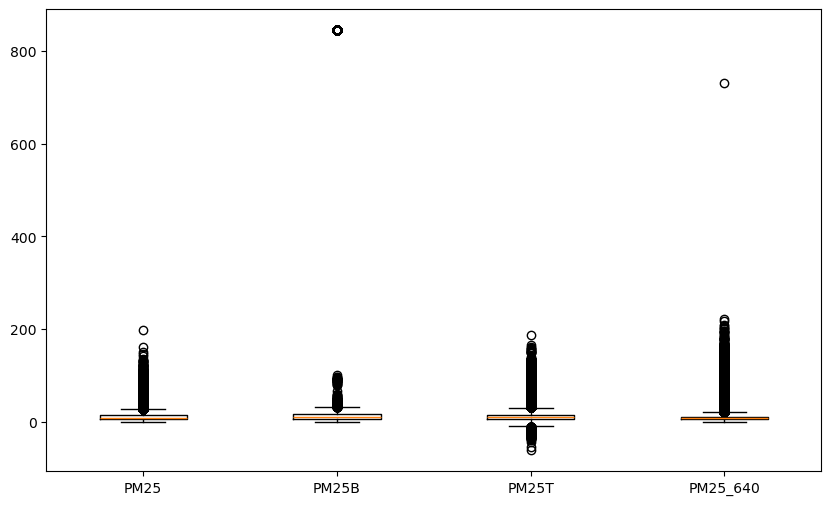

parameter         PM25         PM25B          PM25T       PM25_640
count      69901.00000  52020.000000  193717.000000  151398.000000
mean          11.64527     70.109708      11.826138       8.964480
std           12.06972    214.959117      10.552751       8.550374
min           -2.00000     -2.000000     -62.000000       0.000000
25%            5.00000      6.000000       5.000000       4.700000
50%            8.00000     10.000000       9.000000       7.100000
75%           14.00000     16.000000      15.000000      10.900000
max          197.00000    845.000000     186.000000     731.200000


met_who_standard,False,True
PM25_source,,
PM25,0.256706,0.743294
PM25B,0.217573,0.782427
PM25T,0.228027,0.771973
PM25_640,0.093469,0.906531


In [ ]:
#fig, ax = plt.subplots(figsize=(10, 6))
#for label in pm25_labels:
#    ax.plot(hourly_feat2[label], label=label)

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([hourly_feat2[label].dropna() for label in pm25_labels], tick_labels=pm25_labels)
plt.show()

print(hourly_feat2[pm25_labels].describe(percentiles=[0.25, 0.75]))

pd.crosstab(hourly_feat2['PM25_source'], hourly_feat2['met_who_standard'])
pd.crosstab(hourly_feat2['PM25_source'], hourly_feat2['met_who_standard'], normalize='index')




In [19]:
pd.crosstab(hourly_feat2['year'], hourly_feat2['PM25_source'])
pd.crosstab(hourly_feat2['site'], hourly_feat2['PM25_source'])

PM25_source,PM25,PM25B,PM25T,PM25_640
site,,,,
Avalon,0,10630,54370,15154
Clairton,0,0,0,26546
Lawrenceville,19,41321,903,0
Lawrenceville 2,0,50,0,0
Liberty 2,27278,0,47674,4507
Lincoln,42604,0,0,0
North Braddock,0,0,0,27298
Parkway East,0,0,70927,8895
Pittsburgh,0,0,0,36067


ML model selection

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

imp = SimpleImputer()
#imp_iter = IterativeImputer()
ohe = OneHotEncoder()
mms = MinMaxScaler()

ct = make_column_transformer(
       (imp, ['OUT_T', 'SIGTHETA', 'SONICWD', 'SONICWS', 'BP',
              'OUT_RH', 'RWS', 'WNSP', 'WNDR', 'Peak Wind Gust']),
       (ohe, ['site', 'time_of_day', 'season', 'weekday', 'wind_dir', 'PM25_source']),
       remainder = 'passthrough'
)

ct_scale = make_column_transformer(
       (imp, ['SIGTHETA', 'SONICWD', 'SONICWS', 'BP',
              'OUT_RH', 'RWS', 'WNSP', 'WNDR', 'Peak Wind Gust']),
       (ohe, ['site', 'time_of_day', 'season', 'weekday', 'wind_dir', 'PM25_source']),
       (make_pipeline(imp, mms), ['OUT_T']),
       remainder = 'passthrough'
)

In [ ]:
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor #RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate

pipelines = {
    "Linear Regression": make_pipeline(ct, LinearRegression()),
    #"Ridge Regression": make_pipeline(ct, Ridge()),
    "Lasso Regression": make_pipeline(ct, Lasso()),
    #"Random Forest": make_pipeline(ct, RandomForestRegressor(max_depth=10)),
    "Naive Bayes": make_pipeline(ct, KNeighborsRegressor()),
    "XGBoost": make_pipeline(ct, XGBRegressor()),
    "AdaBoost": make_pipeline(ct, AdaBoostRegressor()),
    "GradientBoost": make_pipeline(ct, HistGradientBoostingRegressor()),
    #"SVR": make_pipeline(ct, scaler, SVR())  # need to scale features for SVR
}

from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, r2_score

val_metrics = {
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "R-Squared": make_scorer(r2_score)
}

# Evaluate pipelines using cross-validation
for name, pipeline in pipelines.items():
    print(f"{name}:")
    scores = cross_validate(pipeline, X, y, cv=5, scoring=val_metrics, return_train_score=False)
    for metric_name in val_metrics.keys():
        mean_score = scores[f'test_{metric_name}'].mean()
        print(f"{metric_name}: {mean_score:.4f}")
    print()



Linear Regression:
RMSE: 127.3317
MAE: 68.8395
R-Squared: -242.2571

Lasso Regression:
RMSE: 67.6767
MAE: 31.7028
R-Squared: -15.2597

XGBoost:
RMSE: 45.6731
MAE: 14.4348
R-Squared: -0.8871

AdaBoost:
RMSE: 43.9766
MAE: 14.9241
R-Squared: -0.2771

GradientBoost:
RMSE: 44.0144
MAE: 13.7178
R-Squared: -0.2162



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (make_scorer, root_mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss)


# Classification on binary discretization of outcome
pipelines_bin = {
    #"Linear Regression": make_pipeline(ct, LinearRegression()),
    #"Ridge Regression": make_pipeline(ct, Ridge()),
    "Logistic Regression": make_pipeline(ct, LogisticRegression(max_iter=1000)),
    #"Lasso Regression": make_pipe  line(ct, Lasso()),
    "Naive Bayes": make_pipeline(ct, GaussianNB()),
    "Complement Naive Bayes": make_pipeline(ct_scale, ComplementNB()), # doesn't like negative temps
    "Random Forest": make_pipeline(ct, RandomForestClassifier(max_depth=25)),
    #"NN": make_pipeline(ct, MLPClassifier()),
    "XGBoost": make_pipeline(ct, XGBClassifier()),
    "AdaBoost": make_pipeline(ct, AdaBoostClassifier(algorithm='SAMME')),
    "GradientBoost": make_pipeline(ct, GradientBoostingClassifier()),
    #"SVR": make_pipeline(ct, scaler, SVR())  # need to scale features for SVR
}

val_metrics_bin = {
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1 Score": make_scorer(f1_score),
    "Cohen's Kappa": make_scorer(cohen_kappa_score),
    "ROC AUC": make_scorer(roc_auc_score, response_method="predict_proba"),
    "Log Loss": make_scorer(log_loss, greater_is_better=False, response_method="predict_proba")
}

for name, pipeline in pipelines_bin.items():
    print(f"{name}:")
    scores = cross_validate(pipeline, X, y_bin, cv=5, scoring=val_metrics_bin, return_train_score=False)
    for metric_name in val_metrics_bin.keys():
        mean_score = scores[f'test_{metric_name}'].mean()
        print(f"{metric_name}: {mean_score:.4f}")
    print()


Logistic Regression:


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

RMSE: 0.4806
MAE: 0.2364
R-Squared: -0.5176
Accuracy: 0.7636
Precision: 0.8107
Recall: 0.9243
F1 Score: 0.8578
ROC AUC: 0.5455
Log Loss: -2.3168

Naive Bayes:
RMSE: 0.5921
MAE: 0.3695
R-Squared: -1.3718
Accuracy: 0.6305
Precision: 0.8249
Recall: 0.6968
F1 Score: 0.7190
ROC AUC: 0.5814
Log Loss: -3.3886

Complement Naive Bayes:
RMSE: 0.6509
MAE: 0.4238
R-Squared: -1.7201
Accuracy: 0.5762
Precision: 0.8429
Recall: 0.5877
F1 Score: 0.6899
ROC AUC: 0.5999
Log Loss: -4.3749

Random Forest:
RMSE: 0.5334
MAE: 0.2913
R-Squared: -0.8698
Accuracy: 0.7087
Precision: 0.8334
Recall: 0.8118
F1 Score: 0.8062
ROC AUC: 0.6521
Log Loss: -0.5655

XGBoost:
RMSE: 0.6256
MAE: 0.4131
R-Squared: -1.6515
Accuracy: 0.5869
Precision: 0.8509
Recall: 0.6264
F1 Score: 0.6470
ROC AUC: 0.6052
Log Loss: -1.2985

AdaBoost:
RMSE: 0.4421
MAE: 0.1954
R-Squared: -0.2545
Accuracy: 0.8046
Precision: 0.8075
Recall: 0.9951
F1 Score: 0.8915
ROC AUC: 0.6736
Log Loss: -0.5473

GradientBoost:
RMSE: 0.5528
MAE: 0.3328
R-Squared: -1

Logistic Regression:


c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jorda\anaconda3\envs\introml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

RMSE: 0.4171
MAE: 0.1740
R-Squared: -0.1167
Accuracy: 0.8260
Precision: 0.8256
Recall: 0.9945
F1 Score: 0.9022
ROC AUC: 0.5583
Log Loss: 6.2705


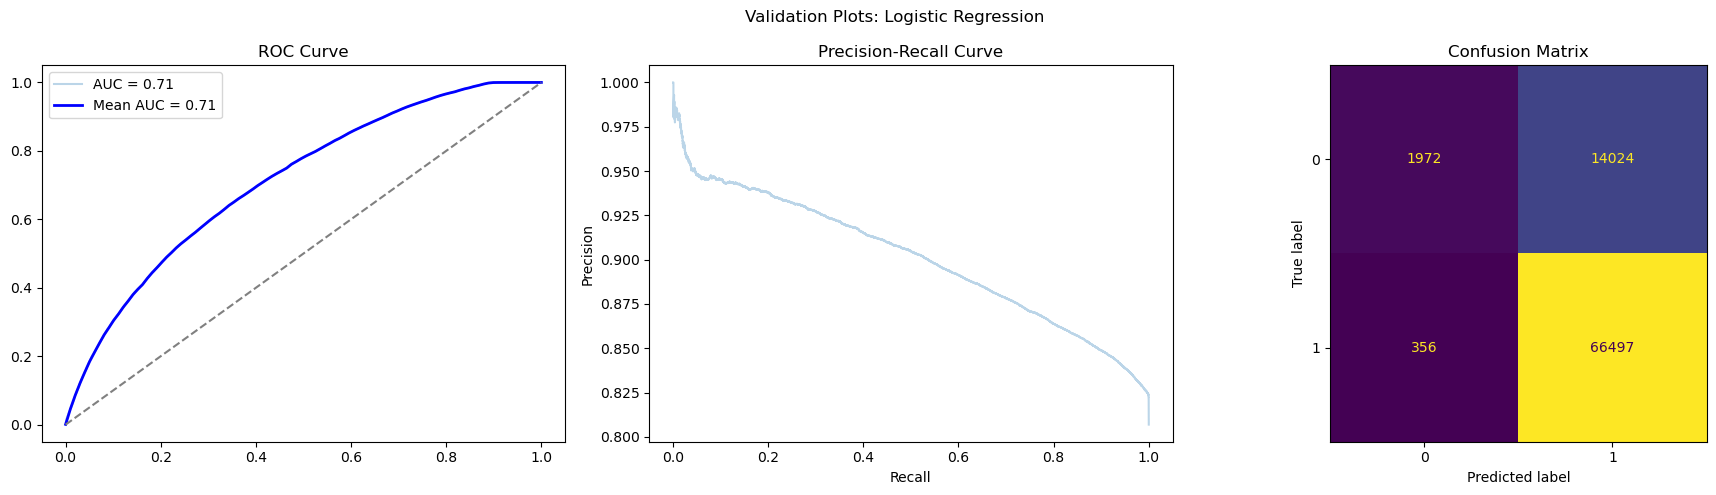

Naive Bayes:
RMSE: 0.4749
MAE: 0.2256
R-Squared: -0.4479
Accuracy: 0.7744
Precision: 0.8490
Recall: 0.8763
F1 Score: 0.8624
ROC AUC: 0.6124
Log Loss: 8.1306


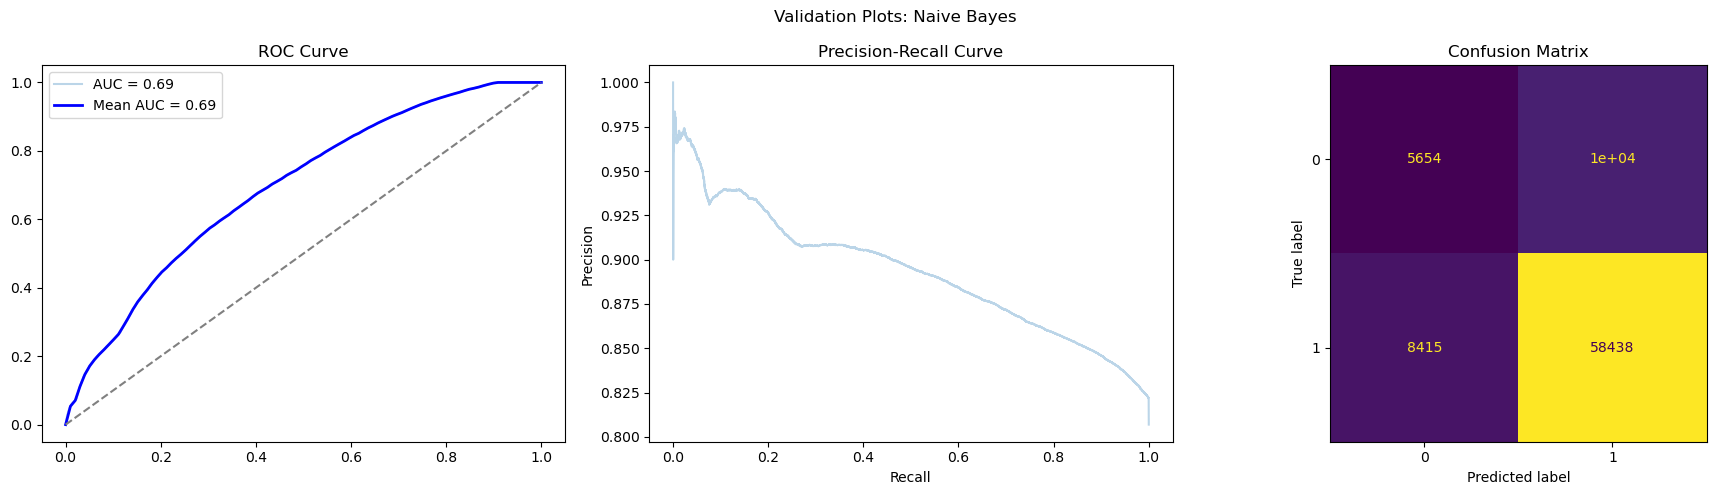

Complement Naive Bayes:
RMSE: 0.6511
MAE: 0.4239
R-Squared: -1.7211
Accuracy: 0.5761
Precision: 0.8441
Recall: 0.5822
F1 Score: 0.6891
ROC AUC: 0.5664
Log Loss: 15.2801


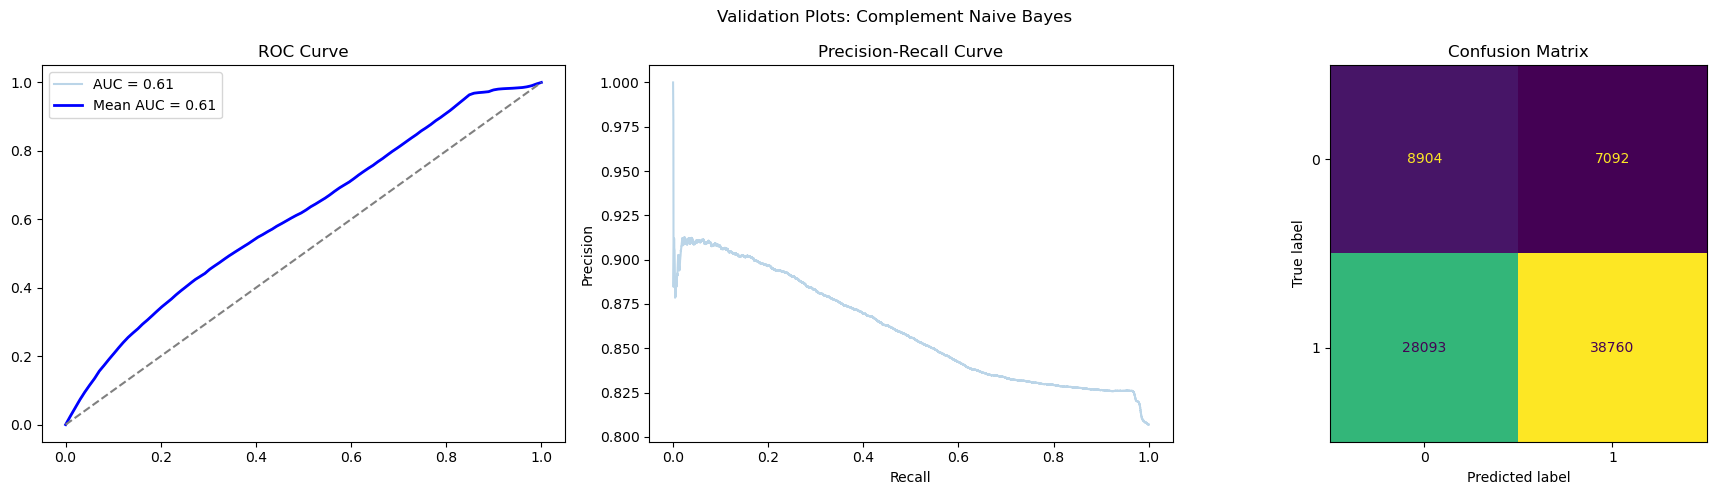

Random Forest:
RMSE: 0.2113
MAE: 0.0447
R-Squared: 0.7133
Accuracy: 0.9553
Precision: 0.9501
Recall: 0.9970
F1 Score: 0.9730
ROC AUC: 0.8891
Log Loss: 1.6098


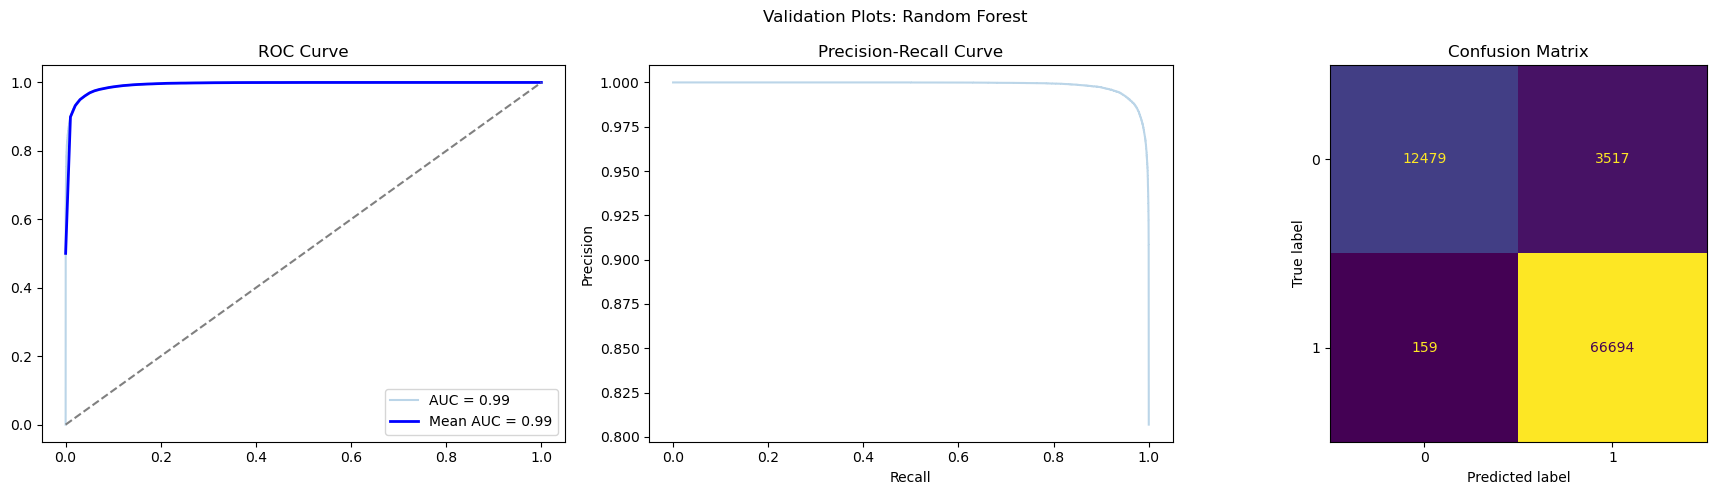

XGBoost:
RMSE: 0.2842
MAE: 0.0808
R-Squared: 0.4814
Accuracy: 0.9192
Precision: 0.9233
Recall: 0.9814
F1 Score: 0.9515
ROC AUC: 0.8204
Log Loss: 2.9122


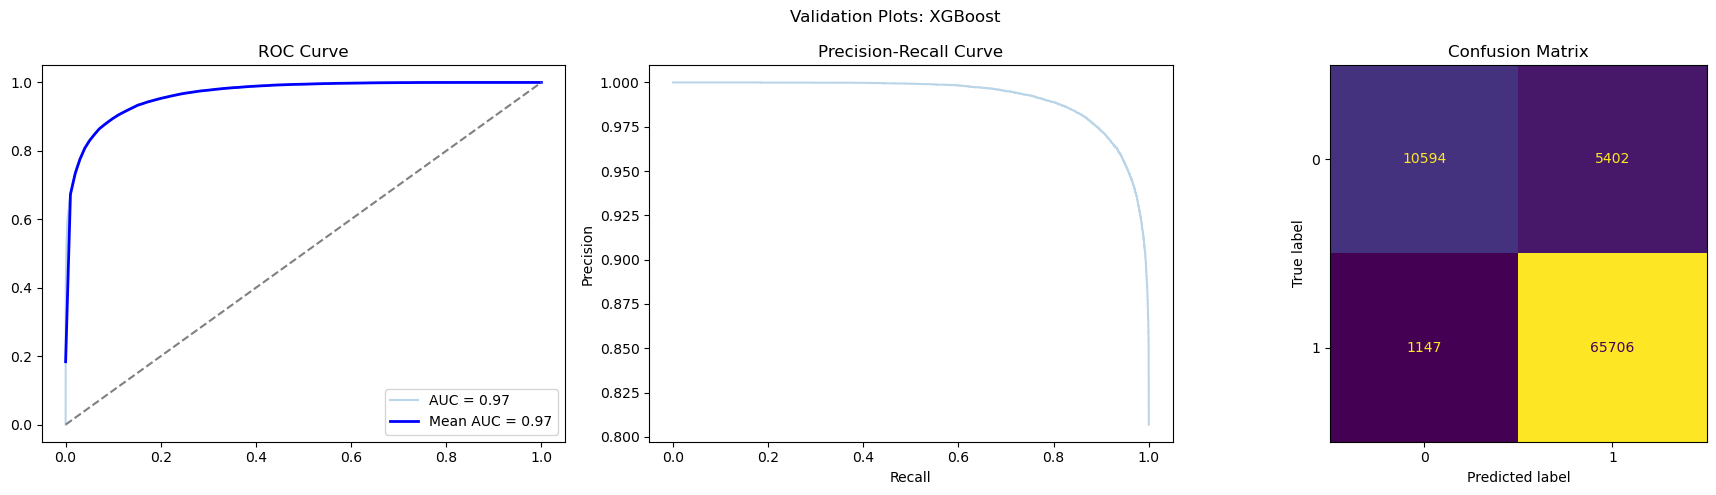

AdaBoost:
RMSE: 0.4126
MAE: 0.1702
R-Squared: -0.0926
Accuracy: 0.8298
Precision: 0.8277
Recall: 0.9965
F1 Score: 0.9043
ROC AUC: 0.5647
Log Loss: 6.1353


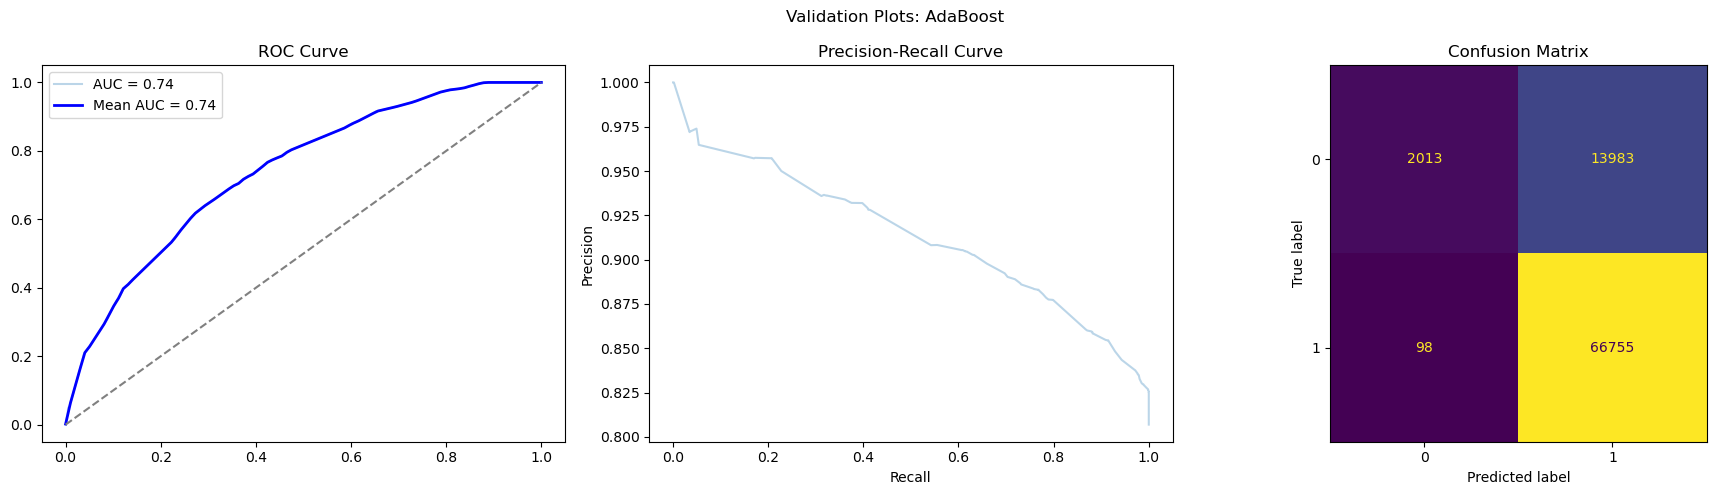

GradientBoost:
RMSE: 0.3956
MAE: 0.1565
R-Squared: -0.0043
Accuracy: 0.8435
Precision: 0.8436
Recall: 0.9896
F1 Score: 0.9108
ROC AUC: 0.6113
Log Loss: 5.6395


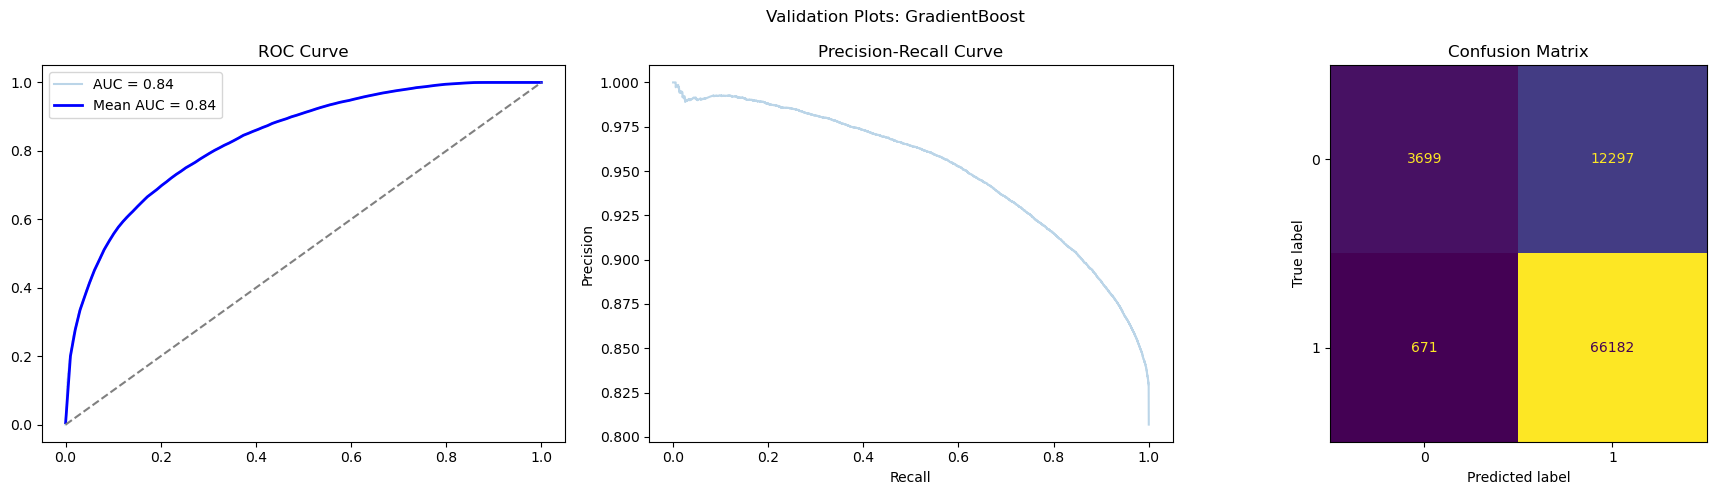

In [8]:
# Plots of classification results. Sadly we need to redo fitting, since cross_validate doesn't
# return everything we need
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

results_bin = {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for name, pipeline in pipelines_bin.items():
    print(f"{name}:")

    results_bin[name] = {"scores": {}, "y_true": [], "y_pred": [], "y_proba": []}

    fold_scores = {metric: [] for metric in val_metrics_bin}

    for train_idx, test_idx in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:,1]

        # Store for plotting
        results_bin[name]["y_true"].append(y_test)
        results_bin[name]["y_pred"].append(y_pred)
        results_bin[name]["y_proba"].append(y_proba)

        # Evaluate metrics
        for metric_name, scorer in val_metrics_bin.items():
            score_func = scorer._score_func
            needs_proba = scorer._kwargs.get("response_method") == "predict_proba"
            input_data = y_proba if needs_proba else y_pred
            score = score_func(y_test, input_data)
            fold_scores[metric_name].append(score)

    # Aggregate scores
    for metric_name, scores in fold_scores.items():
        avg_score = np.mean(scores)
        results_bin[name]["scores"][metric_name] = avg_score
        print(f"{metric_name}: {avg_score:.4f}")

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    all_tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_test, y_proba, y_pred in zip(results_bin[name]["y_true"],
                                       results_bin[name]["y_proba"],
                                       results_bin[name]["y_pred"]):
        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        all_tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        ax[0].plot(fpr, tpr, alpha=0.3, label=f"AUC = {roc_auc:.2f}")

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ax[1].plot(recall, precision, alpha=0.3)

        # Confusion matrix — show one for now
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[2], colorbar=False)
        ax[2].set_title("Confusion Matrix")
        break  # Remove to show for every fold

    # Mean ROC
    mean_tpr = np.mean(all_tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax[0].plot(mean_fpr, mean_tpr, color="b", label=f"Mean AUC = {mean_auc:.2f}", lw=2)
    ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax[0].set_title("ROC Curve")
    ax[0].legend()

    ax[1].set_title("Precision-Recall Curve")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")

    plt.suptitle(f"Validation Plots: {name}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation on two test sets: random split, and temporal
from sklearn.model_selection import TimeSeriesSplit





In [15]:
# Exploration of feature importance of various models

def get_coeffients(pipeline, model_name):
    '''Get coefficients/p-values (proxy for feature importance) for the
    regression models'''
    pipeline.fit(X, y)
    coefficients = pipeline.named_steps[model_name].coef_
    feature_names = ct.get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    return importance_df

linear_importance = get_coeffients(pipelines['Linear Regression'], 'linearregression')
#ridge_importance = get_coeffients(pipelines['Ridge Regression'], 'ridge')
lasso_importance = get_coeffients(pipelines['Lasso Regression'], 'lasso')

print("Linear Regression:")
print(linear_importance)

#print("\nRidge Regression:")
#print(ridge_importance)

print("\nLasso Regression:")
print(lasso_importance)



Linear Regression:
                                 Feature  Coefficient
12     onehotencoder__site_Lawrenceville    52.677937
41   onehotencoder__PM25_source_PM25_640   -36.847109
39      onehotencoder__PM25_source_PM25B    27.784544
15           onehotencoder__site_Lincoln   -22.268922
38       onehotencoder__PM25_source_PM25    22.235972
13   onehotencoder__site_Lawrenceville 2    22.154749
17      onehotencoder__site_Parkway East   -18.844846
14         onehotencoder__site_Liberty 2   -14.940099
40      onehotencoder__PM25_source_PM25T   -13.173407
16    onehotencoder__site_North Braddock   -10.922144
42                       remainder__year     9.099613
23            onehotencoder__season_Fall     7.790308
24          onehotencoder__season_Spring    -6.388836
25          onehotencoder__season_Summer    -6.260274
11          onehotencoder__site_Clairton    -5.809034
26          onehotencoder__season_Winter     4.858803
21    onehotencoder__time_of_day_Morning     4.200922
3        

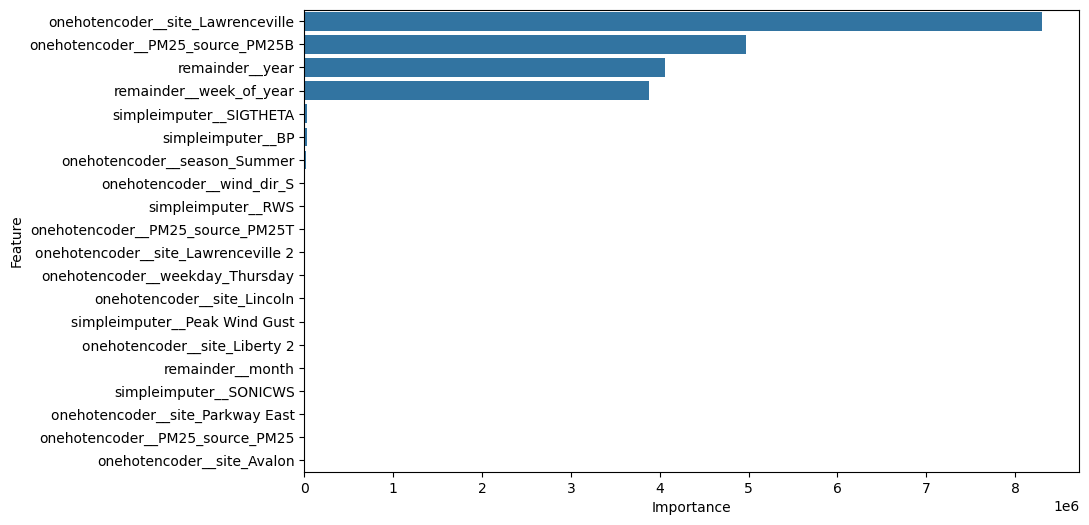

In [16]:
# Feature importance for XGBoost. We need to retrain, since results aren't available from xval above.
from sklearn.model_selection import cross_validate

xgb_cv = cross_validate(pipelines['XGBoost'], X, y, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats = xgb_cv['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance = np.zeros((len(xgb_cv['estimator']), len(xgb_feats)))

# We want to average importance across folds
for i, model in enumerate(xgb_cv['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats)):
        xgb_importance[i, j] = importances.get(f'f{j}', 0)

xgb_importance = pd.DataFrame({'Feature': xgb_feats, 'Importance': xgb_importance.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance.head(20), x='Importance', y='Feature')
plt.show()


In [17]:
# Sklearn doesn't give us p-values, which would be useful to know for the simple linear model
import statsmodels.api as sm

# Preprocess X again, since we can't use pipelines outside sklearn
X_transformed = ct.fit_transform(X)

# Convert pack to df to keep colnames
X_transformed = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out(input_features=X.columns))
X_transformed = sm.add_constant(X_transformed)

# Annoying type conversion for indexes, since sm is finicky
y.index = pd.RangeIndex(start=0, stop=len(y), step=1)

lin_mod = sm.OLS(y, X_transformed.astype(float)).fit()
print(lin_mod.summary())

                            OLS Regression Results                            
Dep. Variable:         PM25_coalesced   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1684.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:41:12   Log-Likelihood:            -2.3654e+06
No. Observations:              414243   AIC:                         4.731e+06
Df Residuals:                  414200   BIC:                         4.731e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
